In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from datetime import datetime

In [2]:
def AR(data_series, p):
    data = pd.DataFrame(data_series.values, columns=["original"])
    if p == 0:
        data["predicted"] = data_series.mean()
        return data

    # set up the lags
    for lag in range(1, p+1):
        data[f"lag_{lag}"] = data["original"].shift(lag)

    # first column in data is the y
    y = data.iloc[p:, 0]
    X = data.iloc[p:, 1:]

    model = LinearRegression().fit(X, y)
    intercept = model.intercept_
    coefs = model.coef_
    print(intercept)
    print(coefs)
    predicted = X.dot(coefs.T) + intercept
    data["predicted"] = predicted
    #data[["original", "predicted"]].plot()
    #plt.show()
    return data
    

In [3]:
def MA(data_series, q):
    data = pd.DataFrame(data_series.values, columns=["error"])
    if q == 0:
        data["predicted"] = data_series.mean()
        return data

    # set up the lags
    for lag in range(1, q+1):
        data[f"lag_{lag}"] = data["error"].shift(lag)

    # first column in data is the y
    y = data.iloc[q:, 0]
    X = data.iloc[q:, 1:]

    model = LinearRegression().fit(X, y)
    intercept = model.intercept_
    coefs = model.coef_

    print(intercept)
    print(coefs)

    predicted = X.dot(coefs.T) + intercept
    data["predicted"] = predicted

    return data

In [191]:
def myARIMA(data_series, p, d, q):
    data = pd.DataFrame(data_series.values, columns=["original"])
    data["Diff"] = data["original"]
    mu = 0
    if d == 0:
        mu = data_series.mean()
    else:
        for _ in range(d):
            data["Diff"] = data["Diff"].diff()

    ar = pd.DataFrame(data["Diff"].values, columns=["original"])
    ar = ar.dropna()
    if p == 0:
        ar["predicted"] = mu
    else:
        # set up the lags
        for lag in range(1, p+1):
            ar[f"lag_{lag}"] = ar["original"].shift(lag)

        X = ar.iloc[p:, 1:]
        y = ar.iloc[p:, 0]
        AR_model = LinearRegression().fit(X, y)
        intercept = AR_model.intercept_
        coefs =  AR_model.coef_

        ar["predicted"] = X.dot(coefs.T) + intercept
    
    ar[["original", "predicted"]].plot()

    data["AR_predicted"] = ar["predicted"]

    ma = pd.DataFrame((data["original"] - data["AR_predicted"]).values, columns=["error"])
    ma = ma.dropna()
    if q == 0:
        ma["predicted"] = 0
    else:
        # set up the lags
        for lag in range(1, q+1):
            ma[f"lag_{lag}"] = ma["error"].shift(lag)

        # first column in data is the y
        X = ma.iloc[q:, 1:]
        y = ma.iloc[q:, 0]

        model = LinearRegression().fit(X, y)
        intercept = model.intercept_
        coefs = model.coef_

        predicted = X.dot(coefs.T) + intercept
        ma["predicted"] = predicted

    ma[["error", "predicted"]].plot()
    
    data["MA_predicted"] = ma["predicted"]
    data["predicted"] = data["AR_predicted"] + data["MA_predicted"]
    #print(data["predicted"])
    #data[["original", "predicted"]].plot()
    return data



In [4]:
rand = pd.Series([51, 92, 14, 71, 60, 20, 82, 86, 74, 74])
print(rand)
print(rand.mean())

0    51
1    92
2    14
3    71
4    60
5    20
6    82
7    86
8    74
9    74
dtype: int64
62.4


In [100]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(rand, order=(1,0,1))
fitted = model.fit()
print(fitted.summary())
print(fitted.resid)
# fitted.predict(start=0, end=9)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   10
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -45.984
Date:                Tue, 19 Oct 2021   AIC                             99.967
Time:                        01:04:35   BIC                            101.178
Sample:                             0   HQIC                            98.640
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.1841      8.046      7.728      0.000      46.414      77.954
ar.L1         -0.1445      1.462     -0.099      0.921      -3.010       2.721
ma.L1         -0.1827      1.478     -0.124      0.9

In [26]:
AR(rand, 0)

,original,predicted
0,51,62.4
1,92,62.4
2,14,62.4
3,71,62.4
4,60,62.4
5,20,62.4
6,82,62.4
7,86,62.4
8,74,62.4
9,74,62.4


In [31]:
rand.diff()

0     NaN
1    41.0
2   -78.0
3    57.0
4   -11.0
5   -40.0
6    62.0
7     4.0
8   -12.0
9     0.0
dtype: float64

In [27]:
residuals = rand - rand.mean()
MA(residuals, 0)

,error,predicted
0,-11.4,1.421085e-15
1,29.6,1.421085e-15
2,-48.4,1.421085e-15
3,8.6,1.421085e-15
4,-2.4,1.421085e-15
5,-42.4,1.421085e-15
6,19.6,1.421085e-15
7,23.6,1.421085e-15
8,11.6,1.421085e-15
9,11.6,1.421085e-15


In [8]:
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

49.01437354776785
[-1.20120726 -0.76324691 -0.4629424  -0.190935    0.13666708]


<AxesSubplot:>

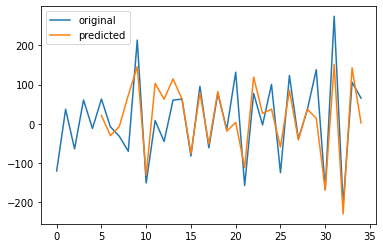

In [9]:
data = pd.read_csv("shampoo.csv", header=0, index_col=0, parse_dates=True, date_parser=parser)
first = data.diff(1).dropna()
ar1 = AR(first, 5)
ar1[["original", "predicted"]].plot()

In [22]:
print(first)
print(first.mean())

            Sales
Month            
1901-02-01 -120.1
1901-03-01   37.2
1901-04-01  -63.8
1901-05-01   61.0
1901-06-01  -11.8
1901-07-01   63.3
1901-08-01   -7.3
1901-09-01  -31.7
1901-10-01  -69.9
1901-11-01  213.6
1901-12-01 -150.6
1902-01-01    8.4
1902-02-01  -44.8
1902-03-01   60.6
1902-04-01   63.2
1902-05-01  -81.9
1902-06-01   95.6
1902-07-01  -61.0
1902-08-01   77.6
1902-09-01  -13.7
1902-10-01  131.7
1902-11-01 -157.1
1902-12-01   77.8
1903-01-01   -2.6
1903-02-01  100.7
1903-03-01 -124.5
1903-04-01  123.4
1903-05-01  -38.0
1903-06-01   36.1
1903-07-01  138.1
1903-08-01 -167.9
1903-09-01  274.4
1903-10-01 -206.7
1903-11-01  106.0
1903-12-01   65.6
Sales    10.882857
dtype: float64


<AxesSubplot:xlabel='Month'>

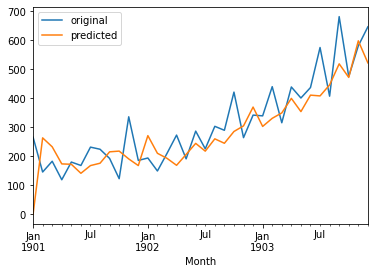

In [194]:
model = ARIMA(data.values, order=(1,1,1))
fitted = model.fit()
# print(fitted.summary())
# print(fitted.resid)
predicted = fitted.predict(start=0, end=len(first))
df = pd.DataFrame()
df["original"] = data.Sales
df["predicted"] = predicted
df[["original", "predicted"]].plot()

    original   Diff  AR_predicted  MA_predicted    predicted
0      266.0    NaN           NaN           NaN          NaN
1      145.9 -120.1           NaN           NaN          NaN
2      183.1   37.2    108.586408           NaN          NaN
3      119.3  -63.8     -5.523335    145.548787   323.125452
4      180.3   61.0     67.744841    183.831270   370.876111
5      168.5  -11.8    -22.788509    174.495976   332.007467
6      231.8   63.3     30.022612    234.406998   432.929609
7      224.5   -7.3    -24.456993    242.388361   449.731368
8      192.8  -31.7     26.758188    278.289009   529.547196
9      122.9  -69.9     44.458619    215.195883   452.454501
10     336.5  213.6     72.169948    148.537583   343.607531
11     185.9 -150.6   -133.488744    289.986919   492.998175
12     194.3    8.4    130.711946    331.883046   648.494993
13     149.5  -44.8     15.368976    137.235154   346.904131
14     210.1   60.6     53.961719    190.913823   394.375541
15     273.3   63.2    -

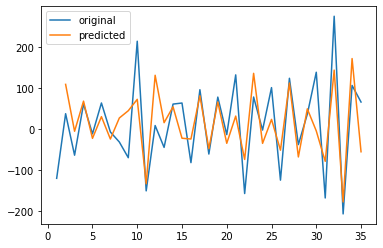

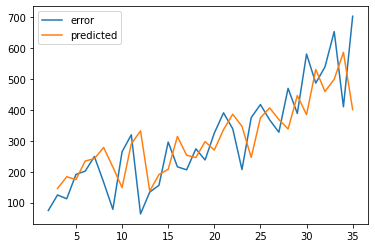

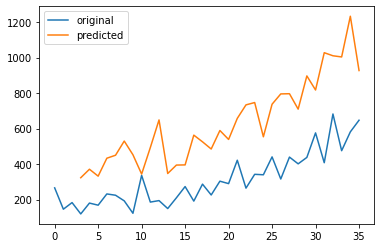

In [195]:
myDf = myARIMA(data.Sales, 1, 1, 1)
myDf["predicted"] += myDf["original"].shift()
myDf[["original", "predicted"]].plot()
print(myDf)

In [178]:
data

,Sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3
1901-06-01,168.5
1901-07-01,231.8
1901-08-01,224.5
1901-09-01,192.8
